In [ ]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 5.9MB/s 


In [ ]:
from pyunpack import Archive 

In [ ]:
Archive('/content/drive/My Drive/segmentation/data.zip').extractall('/content')

In [ ]:
import os
import pandas as pd
import numpy as np
import json
import math 
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw 
from PIL import ImagePath 
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import cv2
import imgaug.augmenters as iaa
import tensorflow as tf
import shutil 
import random

In [ ]:
# Installing segmentation models.
!pip install -U segmentation-models

     |████████████████████████████████| 51kB 5.2MB/s 


# Task 1: Preprocessing

## 1.1 Get all the file name and corresponding json files

In [ ]:
# This snippet will create a dataframe with two columns ['images', 'json']
# The column 'images' will have path to images
# The column 'json' will have path to json files
path = 'data'
G = []
for i in os.listdir(path):
    lst = []
    path1 = os.path.join(path, i)
    print(path1)
    for j in os.listdir(path1):
        path2 = os.path.join(path1, j)
        for k in os.listdir(path2):
            path3 = os.path.join(path2, k)
            lst.append(path3)
    G.append(lst)  

data/images
data/mask


In [ ]:
data = pd.DataFrame(list(zip(G[0], G[1])), columns = ['images', 'json'])
data.head()

images                                           json
0   data/images/235/frame1463_leftImg8bit.jpg  data/mask/235/frame11508_gtFine_polygons.json
1   data/images/235/frame9220_leftImg8bit.jpg   data/mask/235/frame7209_gtFine_polygons.json
2   data/images/235/frame5773_leftImg8bit.jpg   data/mask/235/frame9706_gtFine_polygons.json
3  data/images/235/frame11759_leftImg8bit.jpg   data/mask/235/frame9026_gtFine_polygons.json
4   data/images/235/frame9991_leftImg8bit.jpg   data/mask/235/frame6984_gtFine_polygons.json

In [ ]:
data['images'] = sorted(data['images'])
data['json'] = sorted(data['json'])
data

images                                           json
0      data/images/201/frame0029_leftImg8bit.jpg   data/mask/201/frame0029_gtFine_polygons.json
1      data/images/201/frame0299_leftImg8bit.jpg   data/mask/201/frame0299_gtFine_polygons.json
2      data/images/201/frame0779_leftImg8bit.jpg   data/mask/201/frame0779_gtFine_polygons.json
3      data/images/201/frame1019_leftImg8bit.jpg   data/mask/201/frame1019_gtFine_polygons.json
4      data/images/201/frame1469_leftImg8bit.jpg   data/mask/201/frame1469_gtFine_polygons.json
...                                          ...                                            ...
4003  data/images/429/frame13262_leftImg8bit.jpg  data/mask/429/frame13262_gtFine_polygons.json
4004  data/images/429/frame13699_leftImg8bit.jpg  data/mask/429/frame13699_gtFine_polygons.json
4005  data/images/429/frame15812_leftImg8bit.jpg  data/mask/429/frame15812_gtFine_polygons.json
4006  data/images/429/frame18062_leftImg8bit.jpg  data/mask/429/frame18062_gtFine_polygons.json
4007  data/images/429/frame18403_leftImg8bit.jpg  data/mask/429/frame18403_gtFine_polygons.json

[4008 rows x 2 columns]

If we observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file.

In [ ]:
def grader_1(data_df):
    for i in data_df.values:
        if not (os.path.isfile(i[0]) and os.path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

grader_1(data)

True

In [ ]:
data.shape

(4008, 2)

## 1.2 Structure of sample Json file



*   Each File will have 3 attributes.
  * imgHeight: which tells the height of the image
  * imgWidth: which tells the width of the image
  * objects: it is a list of objects, each object will have multiple attributes,
      * label: the type of the object
      * polygon: a list of two element lists, representing the coordinates of the polygon




### Computing the Unique labels.

Let's see how many unique objects are there in the json file. To see how to get the object from the json file please check [this blog](https://www.geeksforgeeks.org/read-json-file-using-python/).

In [ ]:
total_label = []
for file in data['json'].values:
    f = open(file)
    Data = json.load(f)
    for obj in Data['objects']:
        total_label.append(obj['label'])
    f.close()    

In [ ]:
total_label = set(total_label)
len(total_label)

40

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

len(label_clr)

40

In [ ]:
def get_poly(file):
    label = []
    vertexlist = []
    vertex = []
    f = open(file)
    Data = json.load(f)
    w = Data['imgWidth']
    h = Data['imgHeight']
    for obj in Data['objects']:
        label.append(obj['label'])
        vertex.append(obj['polygon'])
    for each in vertex:
        vertexlist.append([tuple(i) for i in each])
    f.close()
    vertex.clear()
    return w, h, label, vertexlist    

In [ ]:
def grader_3(file):
    w, h, label, vertexlist = get_poly(file)
    print(len((set(label)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


* Here a number is given for each object types, if you see we are having 21 different set of objects.
* Note that we have multiplied each object's number with 10, that is just to make different objects look differently in the segmentation map.
* Before you pass it to the models, you might need to divide the image array /10.

## 1.3 Extracting the polygons from the json files and Creating Image segmentations by drawing set of polygons.

In [ ]:
# shutil.rmtree(out_dir)

In [ ]:
out_dir = os.path.join(path, 'out')
os.mkdir(out_dir)

In [ ]:
n = []
out_path = 'data/out'
final_path = os.path.join(out_path, '201')
os.mkdir(final_path)
n.append('201')
for files in tqdm(data['json'].values):
    w, h, labels, vertexlist = get_poly(files)
    img = Image.new("RGB", (w, h))
    img1 = ImageDraw.Draw(img)
    n.append(files[10:13])
    final_path = os.path.join(out_path, files[10:13])
    if (n[-2] != n[-1]):
        os.mkdir(final_path)
    for i in range(0,len(labels)):
        if len(vertexlist[i])>1:
            img1.polygon(vertexlist[i], fill = label_clr[labels[i]])

    img=np.array(img)
    im = Image.fromarray(img[:,:,0])
    im.save(os.path.join(final_path, files[14:-5]+".png"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
# The obtained mask path is appended in the dataframe.
M = []
for folder in os.listdir(out_path):
    for m in os.listdir(os.path.join(out_path, folder)):
        path = os.path.join(out_path, folder, m)
        M.append(path)

data['mask'] = sorted(M)
data

images  ...                                         mask
0      data/images/201/frame0029_leftImg8bit.jpg  ...   data/out/201/frame0029_gtFine_polygons.png
1      data/images/201/frame0299_leftImg8bit.jpg  ...   data/out/201/frame0299_gtFine_polygons.png
2      data/images/201/frame0779_leftImg8bit.jpg  ...   data/out/201/frame0779_gtFine_polygons.png
3      data/images/201/frame1019_leftImg8bit.jpg  ...   data/out/201/frame1019_gtFine_polygons.png
4      data/images/201/frame1469_leftImg8bit.jpg  ...   data/out/201/frame1469_gtFine_polygons.png
...                                          ...  ...                                          ...
4003  data/images/429/frame13262_leftImg8bit.jpg  ...  data/out/429/frame13262_gtFine_polygons.png
4004  data/images/429/frame13699_leftImg8bit.jpg  ...  data/out/429/frame13699_gtFine_polygons.png
4005  data/images/429/frame15812_leftImg8bit.jpg  ...  data/out/429/frame15812_gtFine_polygons.png
4006  data/images/429/frame18062_leftImg8bit.jpg  ...  data/out/429/frame18062_gtFine_polygons.png
4007  data/images/429/frame18403_leftImg8bit.jpg  ...  data/out/429/frame18403_gtFine_polygons.png

[4008 rows x 3 columns]

In [ ]:
# Data Augmentation functions.
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

# Task 2: Applying Unet to segment the images.

* Please refer the paper for U-Net: https://arxiv.org/abs/1505.04597

  <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* The number of channels in the output will depend on the number of classes in the data, since we know that we are having 21 classes, the number of channels in the output will also be 21.

In [ ]:
# We are importing the pretrained unet from the segmentation models.
# https://github.com/qubvel/segmentation_models
tf.keras.backend.clear_session()
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score
#sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')
#from tensorflow.keras.applications.resnet import preprocess_input

# loading the unet model and using the resnet 50 and initialized weights with Imagenet weights.
# "classes" :different types of classes in the dataset.
backbone = 'resnet50'
preprocess_input = sm.get_preprocessing(backbone)

In [ ]:
# This function is used to visualize the images and it's respective mask.
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# Creating the Batch Dataset for the model.
class Dataset:
    # we will be modifying this CLASSES according to the data/problems
    CLASSES = [0,1,2,3,4,5,6,7,8,9
               ,10,11,12,13,14,15,16,17,18,19,20]
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_names, classes = None):
        
        self.ids = file_names
        # the paths of images
        self.images_fps   = [image_id for image_id in self.ids['images']]
        # the paths of segmentation images
        self.masks_fps    = [image_id for image_id in self.ids['mask']]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)
        
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
        mask = mask / 10
        #image_mask = normalize_image(mask)

        
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        # Data Augmentation.
        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
train, val = train_test_split(data, test_size = 0.2)
train.shape, val.shape

((3206, 3), (802, 3))

In [ ]:
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
BATCH_SIZE = 8
IMAGE_SHAPE = (256, 256, 3)
n_classes = len(CLASSES)

In [ ]:
train_dataset = Dataset(train, classes=CLASSES)
val_dataset  = Dataset(val, classes=CLASSES)

train_dataloader = Dataloder(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = Dataloder(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

(8, 256, 256, 3)


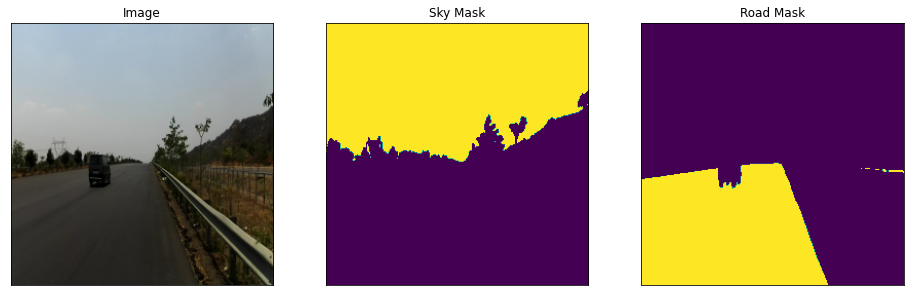

In [ ]:
img, mas = train_dataset[51]
visualize(image = img, sky_mask = mas[:, :, 16], road_mask = mas[:, :, 1])

Sample Image with two mask.

## 2.1 Training Unet.

In [ ]:
tf.keras.backend.clear_session()
model = Unet(backbone_name = backbone, input_shape = IMAGE_SHAPE, classes = n_classes, activation = 'softmax', encoder_freeze = True,
             encoder_weights = 'imagenet', decoder_block_type = 'upsampling')

94593024/94592056 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
_______________________________________________________________________________________

Dice Coefficient = $ \frac {2|A∩B|}{|A|+|B|} $

> Ref : https://www.jeremyjordan.me/semantic-segmentation/#loss




In [ ]:
# Dice loss
optim = tf.keras.optimizers.Adam(0.0001)
focal_loss = sm.losses.cce_dice_loss
model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only = True, save_best_only = True, \
                                       mode = 'max', monitor = 'val_iou_score', verbose = 1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_iou_score', patience = 1, mode = 'max', verbose = 1),
]

In [ ]:
train_steps = train.shape[0]//BATCH_SIZE
valid_steps = val.shape[0]//BATCH_SIZE
len(train_dataloader), train_steps

(400, 400)

In [ ]:
history = model.fit_generator(train_dataloader, steps_per_epoch = train_steps, epochs = 50,\
                              validation_data = val_dataloader, validation_steps = valid_steps,
                              callbacks = callbacks)

Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 0.9334 - iou_score: 0.1015
Epoch 00001: val_iou_score improved from -inf to 0.13969, saving model to ./best_model.h5
400/400 [==============================] - 345s 863ms/step - loss: 0.9334 - iou_score: 0.1015 - val_loss: 0.8684 - val_iou_score: 0.1397
Epoch 2/50
400/400 [==============================] - ETA: 0s - loss: 0.7964 - iou_score: 0.1919
Epoch 00002: val_iou_score improved from 0.13969 to 0.21779, saving model to ./best_model.h5
400/400 [==============================] - 347s 869ms/step - loss: 0.7964 - iou_score: 0.1919 - val_loss: 0.7666 - val_iou_score: 0.2178
Epoch 3/50
400/400 [==============================] - ETA: 0s - loss: 0.7297 - iou_score: 0.2430
Epoch 00003: val_iou_score improved from 0.21779 to 0.25869, saving model to ./best_model.h5
400/400 [==============================] - 350s 874ms/step - loss: 0.7297 - iou_score: 0.2430 - val_loss: 0.7096 - val_iou_score: 0.2587
Epoch 4/50
400/400 [==

<strong>IOU score for Train and Val Data after 50th epoch are 0.4715 and 0.4199.</strong> 

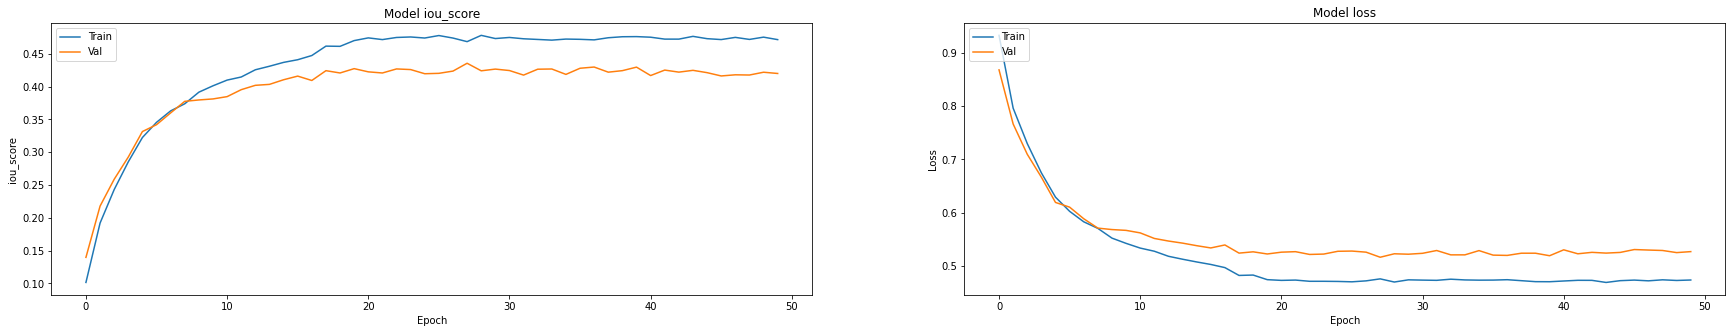

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
images_ = val['images'].values
masks_ = val['mask'].values
lst = np.arange(len(images_))

1/1 [==============================] - 0s 5ms/step


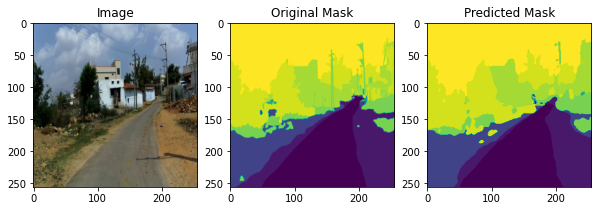

1/1 [==============================] - 0s 9ms/step


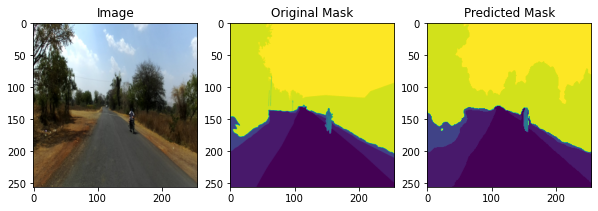

1/1 [==============================] - 0s 9ms/step


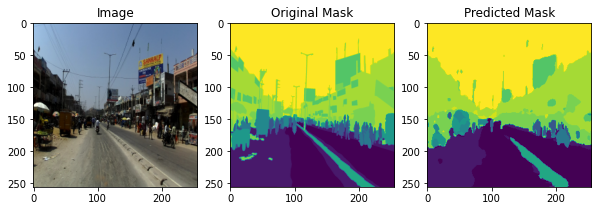

1/1 [==============================] - 0s 9ms/step


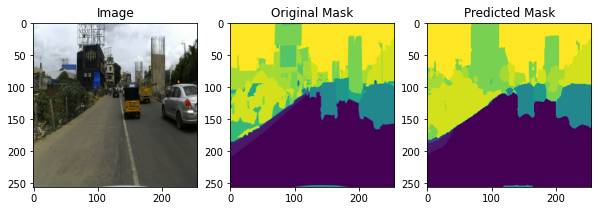

1/1 [==============================] - 0s 19ms/step


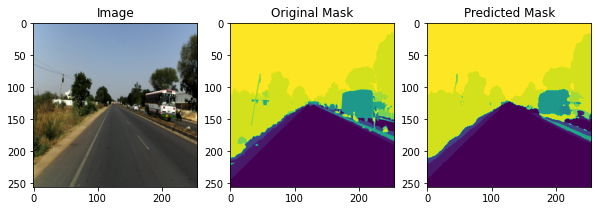

1/1 [==============================] - 0s 19ms/step


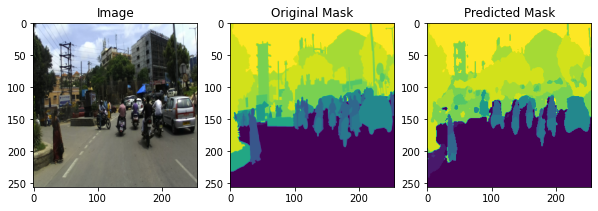

1/1 [==============================] - 0s 19ms/step


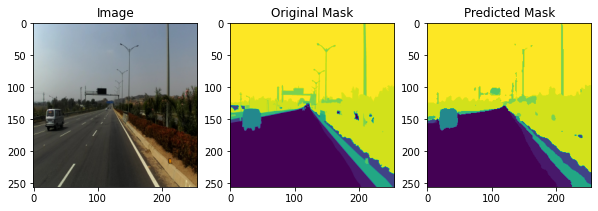

1/1 [==============================] - 0s 19ms/step


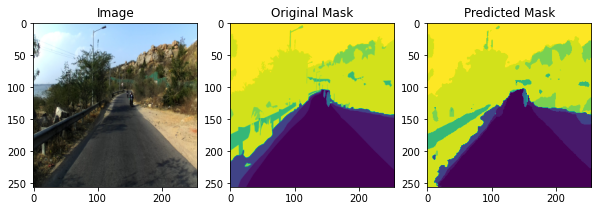

1/1 [==============================] - 0s 20ms/step


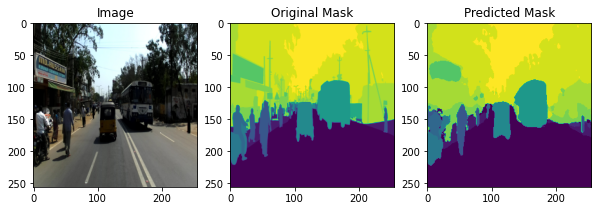

1/1 [==============================] - 0s 19ms/step


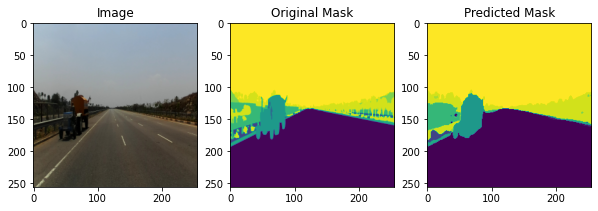

1/1 [==============================] - 0s 19ms/step


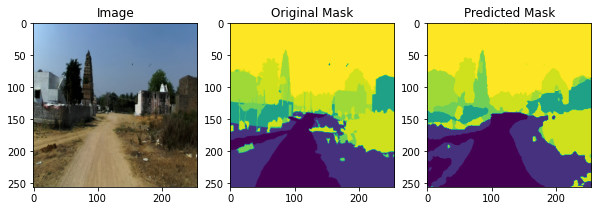

1/1 [==============================] - 0s 19ms/step


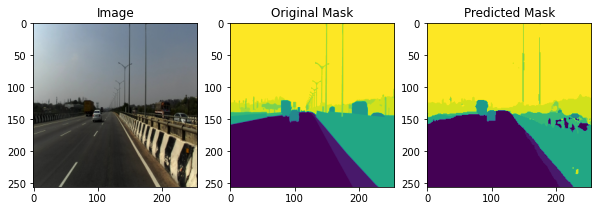

1/1 [==============================] - 0s 19ms/step


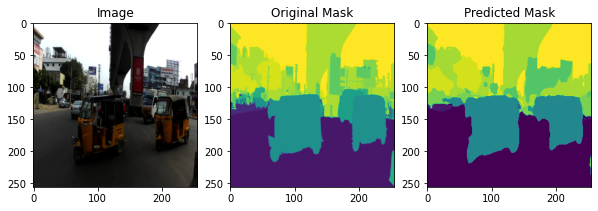

1/1 [==============================] - 0s 19ms/step


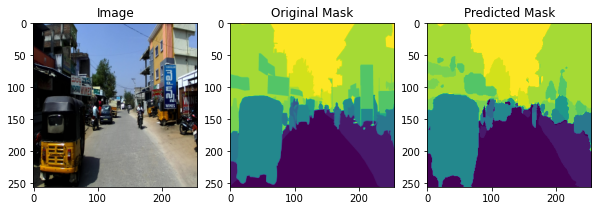

1/1 [==============================] - 0s 18ms/step


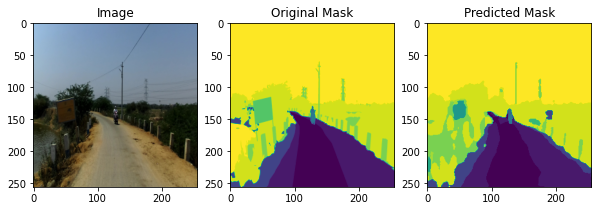

In [ ]:
# Visualizing the predicted mask for val data.
import random
ids = np.random.choice(lst, size = 15, replace = False)
for i in ids:
  image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = np.expand_dims(image, axis=0)

  mask  = cv2.imread(masks_[i], cv2.IMREAD_UNCHANGED)
  mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
  mask = mask / 10
  pred = model.predict(image,verbose=1)
  pred = tf.argmax(pred, axis=-1)

  fig = plt.figure(figsize=(10,6))
  #plt.figure(figsize=(10,6))
  ax1 = fig.add_subplot(131)
  ax1.imshow(image[0,:,:])
  ax2=fig.add_subplot(132)
  ax2.imshow(mask)
  ax3=fig.add_subplot(133)
  ax3.imshow(pred[0,:,:])
  ax1.title.set_text('Image')
  ax2.title.set_text('Original Mask')
  ax3.title.set_text('Predicted Mask')
  plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model

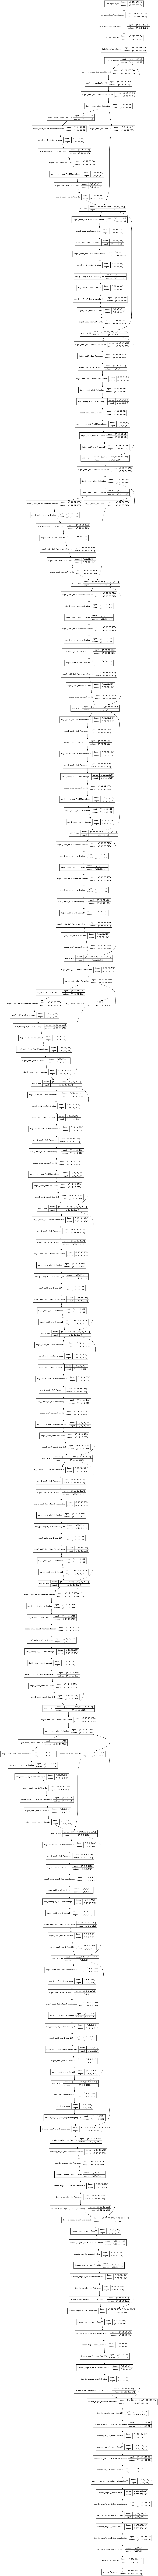

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)